# **Thêm các thư viện cần thiết**

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
import numpy as np
import os

# **Kết nối với drive**

In [3]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NLCS2/

Mounted at /content/drive
/content/drive/MyDrive/NLCS2


# **Tải dữ liệu huấn luyện từ drive**

In [4]:
CHANNELS=3
EPOCHS=20
IMAGE_SIZE=256
BATCH_SIZE=32

In [5]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "./datasets",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
name_classes=dataset.class_names
name_classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# **Trực quan hóa hình ảnh**

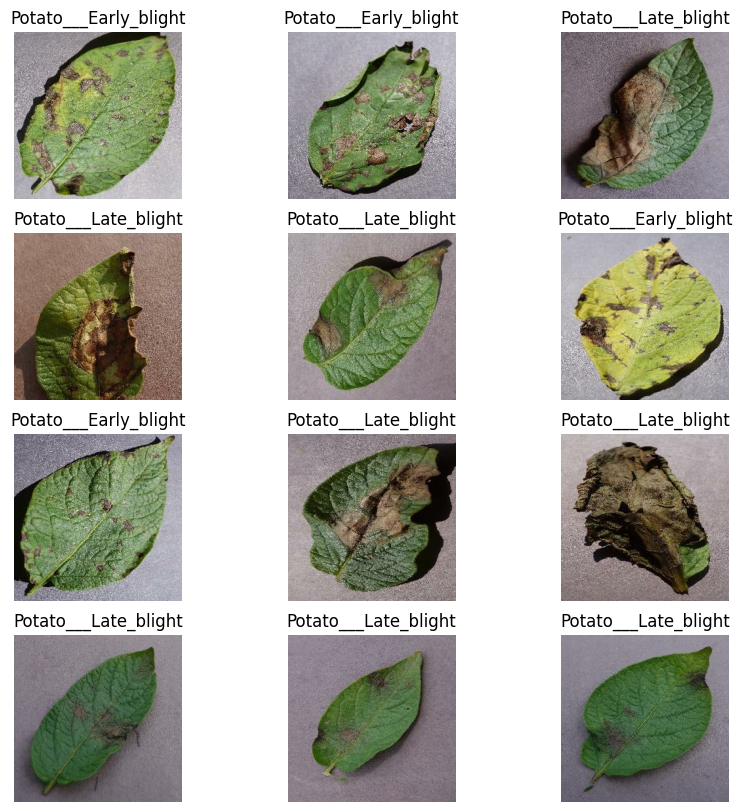

In [7]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
      ax= plt.subplot(4, 3, i+1,)
      plt.imshow(image_batch[i].numpy().astype('uint8'))
      plt.axis('off')
      plt.title(name_classes[label_batch[i]])




# **Chia tập dữ liệu thành 3 tập:**
80% train 10% validate 10% test

In [8]:
def get_datasets_partition_tf(ds, train_split=0.8, validate_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size= len(ds)
  train_size= int(train_split * ds_size)
  validate_size=int(validate_split * ds_size)
  test_size=int(test_split * ds_size)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)
  train_ds= ds.take(train_size)
  validate_ds= ds.skip(train_size).take(validate_size)
  test_ds=ds.skip(train_size).skip(validate_size)
  return train_ds, validate_ds, test_ds

In [9]:
train_ds, val_ds, test_ds= get_datasets_partition_tf(dataset)
print("Dataset batch size", len(dataset))
print("Train batch size= {}, val batch size= {} test batch size ={}".format(len(train_ds), len(val_ds),len(test_ds)))

Dataset batch size 68
Train batch size= 54, val batch size= 6 test batch size =8


In [10]:
# Cache, Improve performance
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **Tiền xử lý dữ liêu**

In [11]:
resize_and_rescale= tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255),
    ]
)

In [12]:
data_augmentation= tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)

# **Xây dưng mô hình**

In [13]:
input_shape= (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=len(name_classes)
model= tf.keras.Sequential(
    [
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3, 3),activation='relu', input_shape=input_shape ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3),activation='relu', ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3),activation='relu', ),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3),activation='relu', ),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ]
)

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 436s 5s/step - loss: 0.6988 - accuracy: 0.6950 - val_loss: 0.5062 - val_accuracy: 0.8281
Epoch 2/20
54/54 [==============================] - 238s 4s/step - loss: 0.4230 - accuracy: 0.8519 - val_loss: 0.4935 - val_accuracy: 0.8333
Epoch 3/20
54/54 [==============================] - 237s 4s/step - loss: 0.3164 - accuracy: 0.8762 - val_loss: 0.3182 - val_accuracy: 0.8125
Epoch 4/20
54/54 [==============================] - 237s 4s/step - loss: 0.2571 - accuracy: 0.8877 - val_loss: 0.3991 - val_accuracy: 0.8385
Epoch 5/20
21/54 [==========>...................] - ETA: 2:17 - loss: 0.1611 - accuracy: 0.9360

# **Đánh giá**

In [ ]:
score=model.evaluate(test_ds)

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']


In [ ]:


plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Train Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validate Accuracy')
plt.title("Train and validation Accuracy")
plt.legend(loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Train Loss')
plt.plot(range(EPOCHS), val_loss, label='Validate Loss')
plt.title("Train and validation Loss")
plt.legend(loc='upper right')
plt.grid()



In [ ]:
def predict(model, img):
  img_arr=tf.keras.preprocessing.image.img_to_array(img)
  img_arr= tf.expand_dims(img_arr, 0)

  predictions= model.predict(img_arr)
  predicted_class= name_classes[np.argmax(predictions[0])]
  confidence= round(100 * np.max(predictions[0]), 2)
  return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence= predict(model,images[i].numpy())
    acctual_class= name_classes[labels[i]]
    plt.title(f"Actual: {acctual_class}\n Predicted: {predicted_class} \n Confidence: {confidence} %")
    plt.axis('off')

In [ ]:
model_names=os.listdir("./models")
if  len(model_names)==0:
  model_names=[0]
version= np.max([int(name) for name in model_names])+1
model.save(f"./models/{version}")